In [1]:
#NOTE: use paimg9 env
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, BCE_Weighted_Reg_focal, compute_loss_for_all_labels_sepatt
from Model import Mutation_MIL_MT_sepAtt #, Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
####################################
######      USERINPUT       ########
####################################
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
TRAIN_SAMPLE_SIZE = "ALLTUMORTILES"
TRAIN_OVERLAP = 100
TEST_OVERLAP = 0
SELECTED_FOLD = 0
TUMOR_FRAC_THRES = 0.9
feature_extraction_method = 'retccl'
INCLUDE_TF = False
INCLUDE_CLUSTER = False
N_CLUSTERS = 4
focal_gamma = 2


####
#model Para
LEARNING_RATE = 0.00001 
BATCH_SIZE  = 1
ACCUM_SIZE = 16  # Number of steps to accumulate gradients
EPOCHS = 100
DROPOUT = 0
DIM_OUT = 128

if INCLUDE_TF == False and INCLUDE_CLUSTER == False:
    N_FEATURE = 2048
elif INCLUDE_TF == True and INCLUDE_CLUSTER == False:
    N_FEATURE = 2049
elif INCLUDE_TF == False and INCLUDE_CLUSTER == True:
    N_FEATURE = 2049
elif INCLUDE_TF == True and INCLUDE_CLUSTER == True:
    N_FEATURE = 2050
            

LOSS_FUNC_NAME = "BCE_Weighted_Reg_focal" #"BCE_Weighted_Reg", "BCE_Weighted_Reg_focal"
REG_COEEF = 0.0000001
REG_TYPE = 'L1'
OPTMIZER = "ADAM"
ATT_REG_FLAG = False
SELECTED_MUTATION = "MT"

if SELECTED_MUTATION == "MT":
    N_LABELS = len(SELECTED_LABEL)
    LOSS_WEIGHTS_LIST = [[1, 50], [1, 100], [1, 50], [1, 100], [1, 100], [1, 10], [1, 30]]  #NEG, POS #WSI 50
else:
    N_LABELS = 1
    LOSS_WEIGHTS_LIST = [[1, 10], [1, 10], [1, 50], [1, 100], [1, 100], [1, 100], [1, 10]]  #NEG, POS

##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
folder_name = feature_extraction_method + '/MAXSS'+ str(TRAIN_SAMPLE_SIZE)  + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + '_TFT' + str(TUMOR_FRAC_THRES) + "/split_fold" + str(SELECTED_FOLD) + "/" 
wsi_path = proj_dir + '/data/OPX/'
in_data_path = proj_dir + 'intermediate_data/model_ready_data/feature_' + folder_name + "model_input/"

if INCLUDE_TF == False and INCLUDE_CLUSTER == False:
    feature_type = "emb_only"
elif INCLUDE_TF == True and INCLUDE_CLUSTER == False:
    feature_type = "emb_and_tf"
elif INCLUDE_TF == False and INCLUDE_CLUSTER == True:
    feature_type = "emb_and_cluster" + str(N_CLUSTERS)
elif INCLUDE_TF == True and INCLUDE_CLUSTER == True:
    feature_type = "emb_and_tf_and_cluster" + str(N_CLUSTERS) 

model_data_path =  in_data_path + feature_type + "/"
    
################################################
#Create output-dir
################################################
outdir0 =  proj_dir + "intermediate_data/pred_out011525/" + folder_name + "/DL_" + feature_type + "/" + SELECTED_MUTATION + "/"
outdir1 =  outdir0  + "/saved_model/"
outdir2 =  outdir0  + "/model_para/"
outdir3 =  outdir0  + "/logs/"
outdir4 =  outdir0  + "/predictions/"
outdir5 =  outdir0  + "/perf/"

create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)
create_dir_if_not_exists(outdir5)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//saved_model/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//model_para/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//logs/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/' already exists.
Directory '

In [3]:
################################################
#     Model ready data 
################################################
train_data_old = torch.load(model_data_path + 'train_data.pth')
test_data_old = torch.load(model_data_path + 'test_data.pth')
val_data = torch.load(model_data_path + 'val_data.pth')

train_ids_old = torch.load(model_data_path + 'train_ids.pth')
test_ids_old = torch.load(model_data_path + 'test_ids.pth')

train_info_old  = torch.load(model_data_path + 'train_info.pth')
test_info_old  = torch.load(model_data_path + 'test_info.pth')

new_data = torch.load(model_data_path + 'newMSI_test_data.pth')
new_ids = torch.load(model_data_path + 'newMSI_test_ids.pth')
new_info  = torch.load(model_data_path + 'newMSI_test_info.pth')

In [4]:
################################################
#Exclude OPX_085, Prostate cancer find in colorectal site, patterns are for CRC, not for prostate
################################################
exc_idx = test_ids_old.index('OPX_085')
inc_idx = [i for i in range(len(test_data_old)) if i not in [exc_idx]]

#Update old testset
test_data_old = Subset(test_data_old, inc_idx)
removed_id =   test_ids_old.pop(exc_idx)  
removed_info = test_info_old.pop(exc_idx)  

In [5]:
train_add_ids = ['OPX_207','OPX_209','OPX_213','OPX_214','OPX_215']
test_add_ids =  [x for x in new_ids if x not in train_add_ids]
print(train_add_ids)
print(test_add_ids)

['OPX_207', 'OPX_209', 'OPX_213', 'OPX_214', 'OPX_215']
['OPX_208', 'OPX_210', 'OPX_211', 'OPX_212', 'OPX_216']


In [6]:
################################################
#Add Ids in train 
################################################
inc_idx = [new_ids.index(x) for x in train_add_ids]
new_data_train = Subset(new_data, inc_idx)
new_id_train =  list(Subset(new_ids, inc_idx))
new_info_train = list(Subset(new_info, inc_idx))

#Combine old and new train data
train_data  = ConcatDataset([train_data_old, new_data_train])
train_ids = train_ids_old +  new_id_train
train_info = train_info_old +  new_info_train

In [7]:
################################################
#Add Ids in test 
################################################
inc_idx = [new_ids.index(x) for x in test_add_ids]
new_data_test = Subset(new_data, inc_idx)
new_id_test =  list(Subset(new_ids, inc_idx))
new_info_test = list(Subset(new_info, inc_idx))

#Combine old and new train data
test_data  = ConcatDataset([test_data_old, new_data_test])
test_ids = test_ids_old +  new_id_test
test_info = test_info_old +  new_info_test

In [8]:
print(len(test_data))
print(len(test_ids))
print(len(test_info))

44
44
44


In [9]:
#count labels in train
train_label_counts = [dt[1] for dt in train_data]
train_label_counts = torch.concat(train_label_counts)
count_ones = (train_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/train_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

tensor([15, 25, 31, 18, 58, 10,  9])
['9.9', '16.4', '20.4', '11.8', '38.2', '6.6', '5.9']


In [10]:
#count labels in test
test_label_counts = [dt[1] for dt in test_data]
test_label_counts = torch.concat(test_label_counts)
count_ones = (test_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/test_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

tensor([ 5,  6, 10,  4, 16,  7,  7])
['11.4', '13.6', '22.7', '9.1', '36.4', '15.9', '15.9']


In [11]:
####################################################
#            Train 
####################################################
set_seed(0)

#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)


#Construct model
model = Mutation_MIL_MT_sepAtt(in_features = N_FEATURE, 
                        act_func = 'tanh', 
                        drop_out = DROPOUT,
                        n_outcomes = N_LABELS,
                        dim_out = DIM_OUT)

model.to(device)

#Optimizer
if OPTMIZER == "ADAM":
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
elif OPTMIZER == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Loss
if LOSS_FUNC_NAME == "BCE_Weighted_Reg":
    loss_func = BCE_Weighted_Reg(REG_COEEF, REG_TYPE, model, reduction = 'mean', att_reg_flag = ATT_REG_FLAG)
elif LOSS_FUNC_NAME == "BCE_Weighted_Reg_focal":
    loss_func = BCE_Weighted_Reg_focal(REG_COEEF, REG_TYPE, model, gamma = focal_gamma, reduction = 'mean', att_reg_flag = ATT_REG_FLAG)
elif LOSS_FUNC_NAME == "BCELoss":
    loss_func = torch.nn.BCELoss()
    

#Model para
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(model)


#OUTPUT MODEL hyper-para
hyper_df = pd.DataFrame({"Target_Mutation": SELECTED_MUTATION,
                         "TRAIN_OVERLAP": TRAIN_OVERLAP,
                         "TEST_OVERLAP": TEST_OVERLAP,
                         "TRAIN_SAMPLE_SIZE": TRAIN_SAMPLE_SIZE,
                         "TUMOR_FRAC_THRES": TUMOR_FRAC_THRES,
                         "N_FEATURE": N_FEATURE,
                         "N_LABELS": N_LABELS,
                         "BATCH_SIZE": BATCH_SIZE,
                         "ACCUM_SIZE": ACCUM_SIZE,
                         "N_EPOCH": EPOCHS,
                         "OPTMIZER": OPTMIZER,
                         "LEARNING_RATE": LEARNING_RATE,
                         "DROPOUT": DROPOUT,
                         "DIM_OUT": DIM_OUT,
                         "REG_TYPE": REG_TYPE,
                         "REG_COEEF": REG_COEEF,
                         "LOSS_FUNC_NAME": LOSS_FUNC_NAME,
                         "LOSS_WEIGHTS_LIST": str(LOSS_WEIGHTS_LIST),
                         "ATT_REG_FLAG": ATT_REG_FLAG,
                         "NUM_MODEL_PARA": total_params}, index = [0])
hyper_df.to_csv(outdir2 + "hyperpara_df.csv")

Number of parameters: 3050504


Epoch0: Train-LOSS:16.87361, Valid-LOSS:9.06624
Epoch10: Train-LOSS:11.49007, Valid-LOSS:7.39242
Epoch20: Train-LOSS:5.65919, Valid-LOSS:5.40410
Epoch30: Train-LOSS:5.13167, Valid-LOSS:5.62890
Epoch40: Train-LOSS:5.10003, Valid-LOSS:5.64161
Epoch50: Train-LOSS:5.07933, Valid-LOSS:5.61369
Epoch60: Train-LOSS:5.05843, Valid-LOSS:5.57841
Epoch70: Train-LOSS:5.03698, Valid-LOSS:5.53900
Epoch80: Train-LOSS:5.01507, Valid-LOSS:5.49666
Epoch90: Train-LOSS:4.99273, Valid-LOSS:5.45182


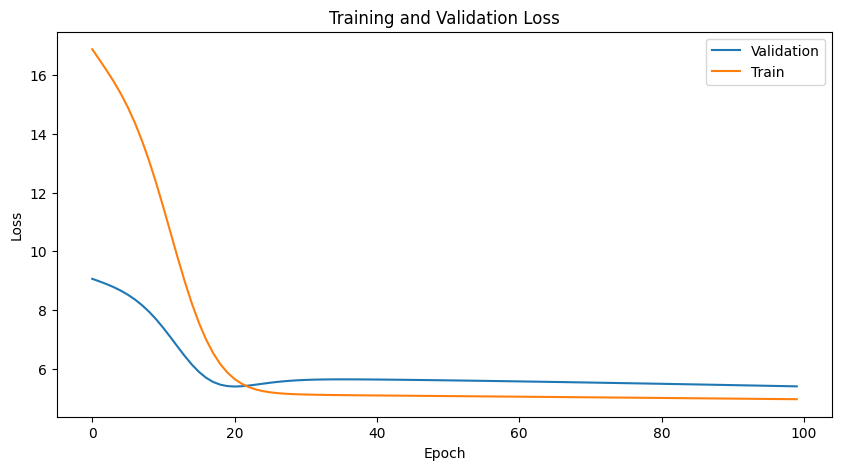

In [12]:
log_message("Start Training", outdir3 + "training_log.txt")
####################################################################################
#Training
####################################################################################
train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    ct = 0
    optmizer_loss = 0
    for x,y,tf in train_loader:
        ct += 1
        #optimizer.zero_grad() #zero the grad
        yhat_list, train_att_list = model(x.to(device)) #Forward

        #compute loss
        loss = compute_loss_for_all_labels_sepatt(yhat_list, y, LOSS_WEIGHTS_LIST, LOSS_FUNC_NAME, loss_func, device, tf , train_att_list, SELECTED_MUTATION, SELECTED_LABEL)

        running_loss += loss.detach().item() #acuumalated batch loss
        optmizer_loss += loss #accumalted loss for optimizer
       
        #Optimize
        if ct % ACCUM_SIZE == 0:
            optmizer_loss = optmizer_loss/ACCUM_SIZE
            optmizer_loss.backward() 
            optimizer.step()  # Optimize
            optmizer_loss = 0
            optimizer.zero_grad() #gradient reset

    #Training loss 
    epoch_loss = running_loss/len(train_loader) #accumulated loss/total # batches (averaged loss over batches)
    train_loss.append(epoch_loss)

    #Validation
    model.eval()
    with torch.no_grad():
        val_running_loss = 0
        for x_val,y_val,tf_val in val_loader:
            val_yhat_list, val_att_list = model(x_val.to(device))
            val_loss = compute_loss_for_all_labels_sepatt(val_yhat_list, y_val, LOSS_WEIGHTS_LIST, LOSS_FUNC_NAME, loss_func, device, tf_val, val_att_list, SELECTED_MUTATION, SELECTED_LABEL)
            val_running_loss += val_loss.detach().item() 
        val_epoch_loss = val_running_loss/len(val_loader) 
        valid_loss.append(val_epoch_loss)

    if epoch % 10 == 0:
        print("Epoch"+ str(epoch) + ":",
              "Train-LOSS:" + "{:.5f}".format(train_loss[epoch]) + ", " +
              "Valid-LOSS:" +  "{:.5f}".format(valid_loss[epoch]))
    
    #Save model parameters
    torch.save(model.state_dict(), outdir1 + "model" + str(epoch))


#Plot LOSS
plot_LOSS(train_loss,valid_loss, outdir1)
log_message("End Training", outdir3 + "training_log.txt")

#SAVE VALIDATION LOSS
valid_loss_df  = pd.DataFrame({"VALID_LOSS": valid_loss})
valid_loss_df.to_csv(outdir1 + "Valid_LOSS.csv")

In [13]:
## #Testing
####################################################################################
#Load model
valid_loss_df = pd.read_csv(outdir1 + "Valid_LOSS.csv")
min_index = valid_loss_df['VALID_LOSS'].idxmin()
print(min_index)
model = Mutation_MIL_MT_sepAtt(in_features = N_FEATURE, 
                        act_func = 'tanh', 
                        drop_out = DROPOUT,
                        n_outcomes = N_LABELS,
                        dim_out = DIM_OUT)
state_dict = torch.load(outdir1 + "model" + str(min_index))

#model2 = Mutation_MIL_MT(in_features = 2048, act_func = 'tanh', drop_out = DROPOUT)
#model_dir = "/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/z_old_mutation_prediction_results/mutation_pred_out_11272024/MAX_SS0_NFEATURES2048/MT/saved_model/MIL/"
#state_dict = torch.load(model_dir + "model" + str(499))
model.load_state_dict(state_dict)
model.to(device)


#Loss function
loss_func = torch.nn.BCELoss()
THRES = 0.55

#predicts
test_pred_prob, test_true_label, test_att, test_loss = prediction_sepatt(test_loader, model, N_LABELS, loss_func, device, SELECTED_MUTATION, SELECTED_LABEL, attention = True)
print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))


#Prediction df
pred_df_list = []
for i in range(0,N_LABELS):
    if N_LABELS > 1:
        cur_pred_df = pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                              "Y_True": [l[i] for l in test_true_label], 
                                              "Pred_Prob" :  [l[i] for l in test_pred_prob],
                                              #"Pred_Prob" :  test_pred_prob,
                                              "OUTCOME": SELECTED_LABEL[i]})
    else:
        cur_pred_df = pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                    "Y_True": [l[i] for l in test_true_label], 
                                    "Pred_Prob" :  test_pred_prob,
                                    "OUTCOME": SELECTED_MUTATION})
        
    pred_df_list.append(cur_pred_df)
pred_df = pd.concat(pred_df_list)

#Add Predict class
pred_df['Pred_Class'] = 0
pred_df.loc[pred_df['Pred_Prob'] > THRES,'Pred_Class'] = 1
pred_df.to_csv(outdir4 + "/pred_df.csv",index = False)


#Compute performance
if SELECTED_MUTATION == "MT":
    perf_df = compute_performance_each_label(SELECTED_LABEL, pred_df, "SAMPLE_LEVEL")
else:
    perf_df = compute_performance_each_label([SELECTED_MUTATION], pred_df, "SAMPLE_LEVEL")
perf_df.to_csv(outdir5 + "/perf.csv",index = True)

print(perf_df.iloc[:,[0,5,6,7,8,9]])
print("AVG AUC:", round(perf_df['AUC'].mean(),2))
print("AVG PRAUC:", round(perf_df['PR_AUC'].mean(),2))
#Use regularization no dropout now has the best performance at avg AUC = 0.61

20
Test-Loss TOTAL: 6.19267
               AUC  Recall  Precision  Specificity    PR_AUC  \
SAMPLE_LEVEL  0.34     1.0       0.11          0.0  0.099192   
SAMPLE_LEVEL  0.54     1.0       0.14          0.0  0.160585   
SAMPLE_LEVEL  0.65     1.0       0.23          0.0  0.319412   
SAMPLE_LEVEL  0.36     1.0       0.09          0.0  0.085667   
SAMPLE_LEVEL  0.27     1.0       0.36          0.0  0.271475   
SAMPLE_LEVEL  0.62     0.0       0.00          1.0  0.226097   
SAMPLE_LEVEL  0.59     0.0       0.00          1.0  0.197774   

                                                       OUTCOME  
SAMPLE_LEVEL                                                AR  
SAMPLE_LEVEL  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL                                              PTEN  
SAMPLE_LEVEL                                               RB1  
SAMPLE_LEVEL                                              TP53  
SAMPLE_LEVEL                           TMB_HIGHorINTERMEDITATE  
SAMP